In [1]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def dydt(y, t, A):
    return torch.matmul(y,A)

In [3]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

In [4]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [5]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        #self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(self.dim, self.dim*self.dim)
        
    def forward(self, y):
        #y = self.hidden_layer(y)
        #y = torch.relu(y)
        #y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

In [6]:
def train_model(model, x_data, y_data, epochs=300, lr=0.05):
    training_loss = []
    y_pred_list = []
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in tqdm(range(epochs)):
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')[1]
        loss = criterion(y_pred, y_data)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param -= lr * param.grad
                    param.grad.zero_()
        if epoch % 20 == 0:
            predict = torch.diag(neural_ode.get_A())
            training_loss.append(loss.detach().numpy().item())
            y_pred_list.append(predict.detach().numpy())
    return training_loss, y_pred_list

In [7]:
dim = 10 #dimension of the matrix
mean = 1 #mean of the diagonal values
n_samples=100 #number of samples
stddevs=[i/10 for i in range(1,11)] #standard deviations from 0.1 to 1
file_path = 'data'

In [12]:
x_data = torch.randn(dim)
x_data

tensor([-0.8549,  0.0833,  0.1077, -0.3843,  0.5436,  1.5369, -1.3669, -0.2019,
         0.3593,  0.0068])

In [9]:
torch.matmul(x_data,torch.matrix_exp(torch.eye(10)))

tensor([ 4.6861,  4.6021,  6.3461,  2.8007,  0.7454,  0.9002, -4.7371,  0.5909,
         1.3117,  2.4732])

In [10]:
A_true=torch.eye(dim)

In [11]:
phi_A(x_data,A_true)

tensor([ 4.6861,  4.6021,  6.3461,  2.8007,  0.7454,  0.9002, -4.7371,  0.5909,
         1.3117,  2.4732])

In [14]:
A_true=-torch.eye(dim)

x_data = torch.randn(n_samples, dim)
#y_data = phi_A(x_data, A_true)
y_data= -x_data


neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
training_loss,y_pred_list = train_model(neural_ode, x_data, y_data,epochs=1000)
A_estimated = neural_ode.get_A()
frob_losses=np.linalg.norm((A_true-A_estimated).detach().numpy())

100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


In [15]:
data = {'training_loss': training_loss, 'y_pred':y_pred_list,'frob':frob_losses}
print(data)

{'training_loss': [13.71993637084961, 4.326269626617432, 3.091426372528076, 2.562598943710327, 2.261657238006592, 2.0648958683013916, 1.9250849485397339, 1.820055365562439, 1.7379428148269653, 1.6717894077301025, 1.6172306537628174, 1.5713801383972168, 1.5322495698928833, 1.498421311378479, 1.468855857849121, 1.4427728652954102, 1.4195739030838013, 1.3987929821014404, 1.380060076713562, 1.3630781173706055, 1.3476063013076782, 1.3334465026855469, 1.3204336166381836, 1.308430552482605, 1.2973212003707886, 1.2870063781738281, 1.2774018049240112, 1.2684344053268433, 1.2600418329238892, 1.252168893814087, 1.244767665863037, 1.2377957105636597, 1.2312161922454834, 1.2249958515167236, 1.21910560131073, 1.2135192155838013, 1.2082128524780273, 1.2031660079956055, 1.198359489440918, 1.19377601146698, 1.189400315284729, 1.185218095779419, 1.1812167167663574, 1.1773842573165894, 1.1737101078033447, 1.1701843738555908, 1.1667983531951904, 1.1635433435440063, 1.1604119539260864, 1.1573971509933472],

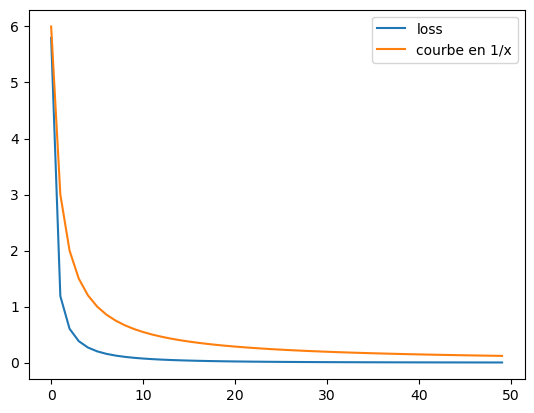

In [44]:
loss=data["training_loss"]

x = np.linspace(1, len(loss), num=len(loss))
y = 6/x

# tracé des deux courbes sur le même graphique
plt.plot(loss, label='loss')
plt.plot(y, label='courbe en 1/x')
plt.legend()
plt.show()

In [34]:
A_estimated

Parameter containing:
tensor([[-8.4484e-01, -2.0422e-03, -3.6087e-04, -2.4732e-02, -3.1859e-02,
         -1.2517e-02, -1.5567e-02,  1.9247e-02,  8.4842e-03,  2.1266e-02],
        [-2.0422e-03, -8.4102e-01, -1.3935e-02,  1.8842e-02,  9.2961e-04,
         -2.8639e-02,  1.1925e-04, -7.4272e-03, -4.1580e-03,  2.7873e-02],
        [-3.6095e-04, -1.3935e-02, -8.8017e-01, -9.0461e-04, -1.8528e-02,
          1.5231e-02, -3.2782e-03, -1.5080e-02,  9.2355e-03,  3.4469e-04],
        [-2.4732e-02,  1.8842e-02, -9.0448e-04, -8.8509e-01,  1.5920e-02,
         -9.9697e-04, -1.9976e-03, -2.0264e-02,  2.2432e-02, -1.3324e-03],
        [-3.1859e-02,  9.2962e-04, -1.8527e-02,  1.5920e-02, -8.9140e-01,
          1.5397e-02,  9.9756e-03,  5.9182e-03, -1.4802e-02,  1.1076e-04],
        [-1.2517e-02, -2.8639e-02,  1.5231e-02, -9.9690e-04,  1.5397e-02,
         -8.8902e-01, -5.8800e-04, -1.4180e-02, -1.5285e-03,  3.4647e-03],
        [-1.5567e-02,  1.1918e-04, -3.2783e-03, -1.9977e-03,  9.9755e-03,
         -